# DeepLearning day5 project

(자연어)
- 영화 리뷰 데이터셋
https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

## 1. 모델링의 목적
- 영화 리뷰의 긍정/부정 여부를 분류하기 위한 모델링

## 2. 모델 선정 이유
- lstm 모델 사용. LSTM 모델은 장기 의존성을 학습할 수 있기에 긴 문장의 내부나 문장 간 의미적 연결을 파악할 수 있다. 또한, 순차적 특성을 고려하기에 문장과 같이 순서가 중요한 자연어 데이터에 적합한 모델이라고 판단했다.

## 3. 데이터셋 처리 및 모델링 과정

In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import urllib.request
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import os
import tensorflow as tf
from tensorflow.keras.datasets import imdb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, Embedding
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

In [2]:
from google.colab import files

# 로컬 파일을 업로드합니다.
uploaded = files.upload()

# 업로드한 파일의 이름을 출력합니다.
for filename in uploaded.keys():
    print('Uploaded file:', filename)

Saving IMDB Dataset.csv to IMDB Dataset.csv
Uploaded file: IMDB Dataset.csv


In [40]:
for filename in uploaded.keys():
    df = pd.read_csv(filename)
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


- 자료 전처리

In [41]:
df.isnull().sum()

review       0
sentiment    0
dtype: int64

In [42]:
df['sentiment'].value_counts()

sentiment
positive    25000
negative    25000
Name: count, dtype: int64

In [43]:
df.duplicated().sum() # 중복이 418개로 전체 데이터인 5만게에 비해 작은 숫자이므로 중복 제거X

418

최대 리뷰 길이: 2470
최소 리뷰 길이: 4
평균 리뷰 길이: 231.15694
최빈 리뷰 길이: 127
최빈 리뷰 길이의 빈도: 387


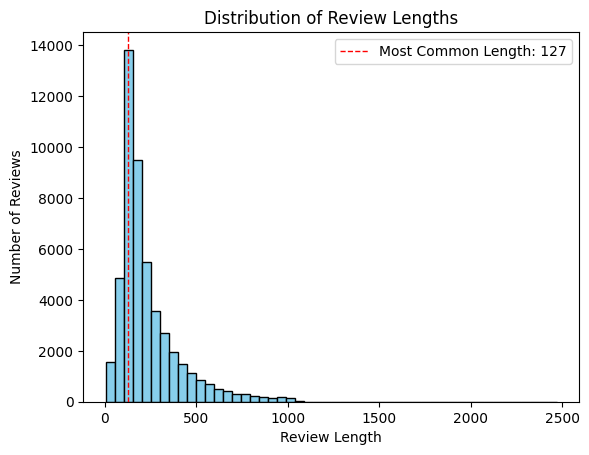

In [49]:
import matplotlib.pyplot as plt

# 각 리뷰의 길이 계산
review_lengths = [len(review.split()) for review in df['review']]

# 최대, 최소, 평균 리뷰의 길이 출력
max_length = max(review_lengths)
min_length = min(review_lengths)
avg_length = sum(review_lengths) / len(review_lengths)
print("최대 리뷰 길이:", max_length)
print("최소 리뷰 길이:", min_length)
print("평균 리뷰 길이:", avg_length)

# 리뷰 길이의 빈도를 계산
length_counts = Counter(review_lengths)
most_common_length, most_common_freq = length_counts.most_common(1)[0]
print("최빈 리뷰 길이:", most_common_length)
print("최빈 리뷰 길이의 빈도:", most_common_freq)

# 히스토그램으로 리뷰의 길이 분포 시각화
plt.hist(review_lengths, bins=50, color='skyblue', edgecolor='black')
plt.axvline(x=most_common_length, color='red', linestyle='dashed', linewidth=1, label=f'Most Common Length: {most_common_length}')
plt.title('Distribution of Review Lengths')
plt.xlabel('Review Length')
plt.ylabel('Number of Reviews')
plt.legend()
plt.show()


- 최빈 길이 중심으로 max_len 정함. --> 150

In [50]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [51]:
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# 정규 표현식을 사용하여 HTML 태그 제거 함수
def remove_html_tags(text):
  clean = re.compile('<.*?>')
  return re.sub(clean, '', text)

def preprocess(sen):
     # 문장을 소문자로 변환
     sentence = sen.lower()

     # HTML 태그 제거
     sentence = remove_html_tags(sentence)

     # 구두점과 숫자 제거
     sentence = re.sub('[^a-zA-Z]', ' ', sentence)

     # 단일 문자 제거
     sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

     # 다중 공백 제거
     sentence = re.sub(r'\s+', ' ', sentence)

     # 불용어 제거
     pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')
     sentence = pattern.sub('', sentence)

     return sentence

In [52]:
df['preprocessed_review'] = df['review'].apply(preprocess)
df['sentiment']=df['sentiment'].map({'positive': 1, 'negative': 0})

In [54]:
max_length = 150

tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['preprocessed_review'])  # 텍스트 데이터를 기반으로 단어 사전 생성
X = tokenizer.texts_to_sequences(df['preprocessed_review'])
X = pad_sequences(X, padding='post', maxlen=max_length)  # 패딩 적용
y = np.array(df['sentiment'])

In [55]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=71)

In [56]:
vocab_size = len(tokenizer.word_index)+1
vocab_size

101246

In [66]:
# lstm 모델 구성

embedding_dim = 100 # 임베딩 차원
hidden_units = 128 # LSTM 유닛 수

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
    tf.keras.layers.LSTM(units=hidden_units, dropout=0.2),
    tf.keras.layers.Dense(units=1, activation='sigmoid')
])


# 모델 요약 출력
model.summary()

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4) # 조기 종료 콜백: 검증 데이터 손실이 4회 증가 시

mc = ModelCheckpoint('lstm_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True) # 검증 데이터의 정확도(val_acc)가 이전보다 좋아질 경우에만 모델을 저장

# 모델 컴파일
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

# 모델 훈련
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=128,verbose=1, validation_data=(X_test, y_test))

# 모델 평가
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Accuracy:", accuracy)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 150, 100)          10124600  
                                                                 
 lstm_9 (LSTM)               (None, 128)               117248    
                                                                 
 dense_5 (Dense)             (None, 1)                 129       
                                                                 
Total params: 10241977 (39.07 MB)
Trainable params: 10241977 (39.07 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/15
313/313 [==============================] - ETA: 0s - loss: 0.6336 - acc: 0.6304
Epoch 1: val_acc improved from -inf to 0.62940, saving model to lstm_model.h5
313/313 [==============================] - 273s 865ms/step - loss: 0.6336 - acc: 0.6304 - val_loss: 0.6664 

## 4. 결과 (성능 평가 결과, 인사이트, 한계점&보완할 점 등)

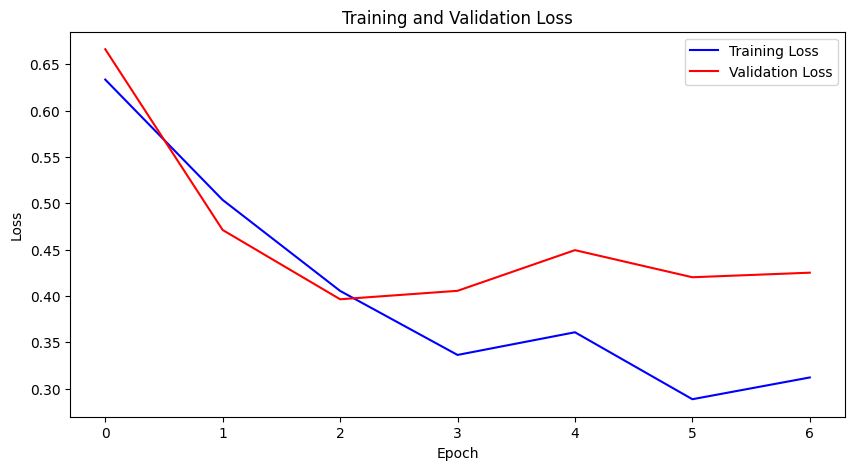

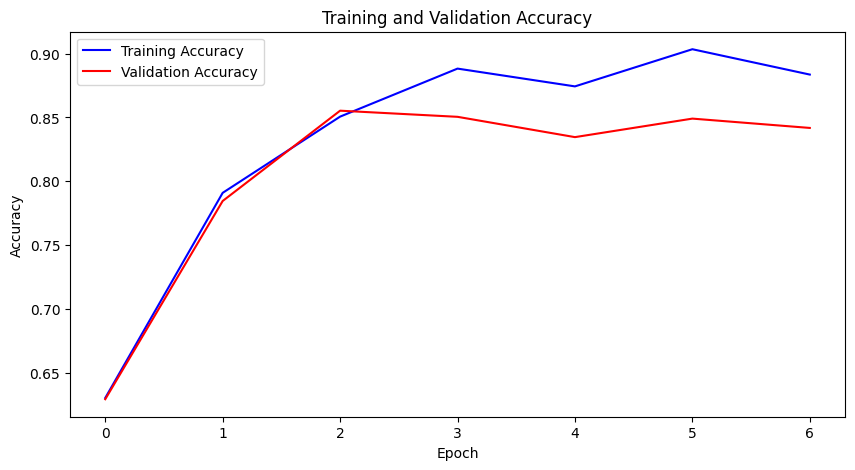

In [67]:
import matplotlib.pyplot as plt

# 훈련 과정에서 손실과 정확도를 추출합니다
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['acc']
val_acc = history.history['val_acc']

# 손실 그래프를 그립니다
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Training Loss', color='blue')
plt.plot(val_loss, label='Validation Loss', color='red')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 정확도 그래프를 그립니다
plt.figure(figsize=(10, 5))
plt.plot(train_acc, label='Training Accuracy', color='blue')
plt.plot(val_acc, label='Validation Accuracy', color='red')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [68]:
loaded_model = load_model('lstm_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

313/313 [==============================] - 28s 87ms/step - loss: 0.3964 - acc: 0.8553

 테스트 정확도: 0.8553


In [69]:
word_to_index = imdb.get_word_index()
index_to_word = {}
for key, value in word_to_index.items():
    index_to_word[value+3] = key

In [70]:
def sentiment_predict(new_sentence):
  # 알파벳과 숫자를 제외하고 모두 제거 및 알파벳 소문자화
  new_sentence = re.sub('[^0-9a-zA-Z ]', '', new_sentence).lower()
  encoded = []

  # 띄어쓰기 단위 토큰화 후 정수 인코딩
  for word in new_sentence.split():
    try :
      # 단어 집합의 크기를 100,000으로 제한.
      if word_to_index[word] <= 100000:
        encoded.append(word_to_index[word]+3)
      else:
      # 100,000 이상의 숫자는 <unk> 토큰으로 변환.
        encoded.append(2)
    # 단어 집합에 없는 단어는 <unk> 토큰으로 변환.
    except KeyError:
      encoded.append(2)

  pad_sequence = pad_sequences([encoded], maxlen=max_length)
  score = float(loaded_model.predict(pad_sequence)) # 예측

  if(score > 0.5):
    print("{:.2f}% 확률로 긍정 리뷰입니다.".format(score * 100))
  else:
    print("{:.2f}% 확률로 부정 리뷰입니다.".format((1 - score) * 100))


In [74]:
test_input = "This movie was just way too overrated. The fighting was not professional and in slow motion. I was expecting more from a 200 million budget movie. The little sister of T.Challa was just trying too hard to be funny. The story was really dumb as well. Don't watch this movie if you are going because others say its great unless you are a Black Panther fan or Marvels fan."

sentiment_predict(test_input)


1/1 [==============================] - 0s 88ms/step
78.00% 확률로 부정 리뷰입니다.


<ipython-input-70-ea3017fb6912>:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  score = float(loaded_model.predict(pad_sequence)) # 예측
